# Analyzing the Bookmaker Overround - R

In [ ]:
library(tidyverse)
library(readr)
library(ggplot2)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.6
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.1     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.2.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [ ]:
# Reproducibility & options
set.seed(123)
options(stringsAsFactors = FALSE)


In [7]:
# Parameters
n_events <- 5000
probs <- c(0.8, 0.2)
bets <- c(50, 50)
odds_fair <- c(1.25, 5)
odds_misspricing <- c(1.31, 5.25)
odds_overrounding <- c(1.19, 4.75)


In [25]:
# Core functions: profit calc (vectorized), Monte Carlo, and helper to tidy results
calculate_profit <- function(odds, bets, n_events, probs) {
  outcomes <- sample(c(0L,1L), size = n_events, replace = TRUE, prob = probs)
  outcomes_tail <- outcomes[-1]

  profit_values <- ifelse(outcomes_tail == 0L,
                          -((odds[1] - 1) * bets[1]) + bets[2],
                          -((odds[2] - 1) * bets[2]) + bets[1])
  cumsum(profit_values)
}

monte_carlo_simulation <- function(odds, bets, n_simulations = 1000, n_events = NULL, probs = NULL) {
  if (is.null(n_events)) n_events <- get("n_events", envir = .GlobalEnv)
  if (is.null(probs)) probs <- get("probs", envir = .GlobalEnv)

  # Precompute the length for FUN.VALUE without referencing default promises
  fun_val_len <- n_events - 1

  vapply(seq_len(n_simulations),
         function(i) calculate_profit(odds, bets, n_events, probs),
         FUN.VALUE = numeric(fun_val_len))
}

mc_matrix_to_long <- function(mat) {
  as_tibble(mat) %>%
    mutate(event = row_number()) %>%
    pivot_longer(cols = -event, names_to = "sim", values_to = "cumprofit")
}

In [26]:
# Run simulations
sims_fair <- monte_carlo_simulation(odds_fair, bets, n_simulations = 1000)
sims_mis  <- monte_carlo_simulation(odds_misspricing, bets, n_simulations = 1000)
sims_ovr  <- monte_carlo_simulation(odds_overrounding, bets, n_simulations = 1000)

df_fair_long <- mc_matrix_to_long(sims_fair)  %>% mutate(strategy = "Fair")
df_mis_long  <- mc_matrix_to_long(sims_mis)   %>% mutate(strategy = "Misspricing")
df_ovr_long  <- mc_matrix_to_long(sims_ovr)   %>% mutate(strategy = "Overrounding")

df_all <- bind_rows(df_fair_long, df_mis_long, df_ovr_long)
means <- df_all %>% group_by(strategy, event) %>% summarize(mean_cum = mean(cumprofit), .groups="drop")


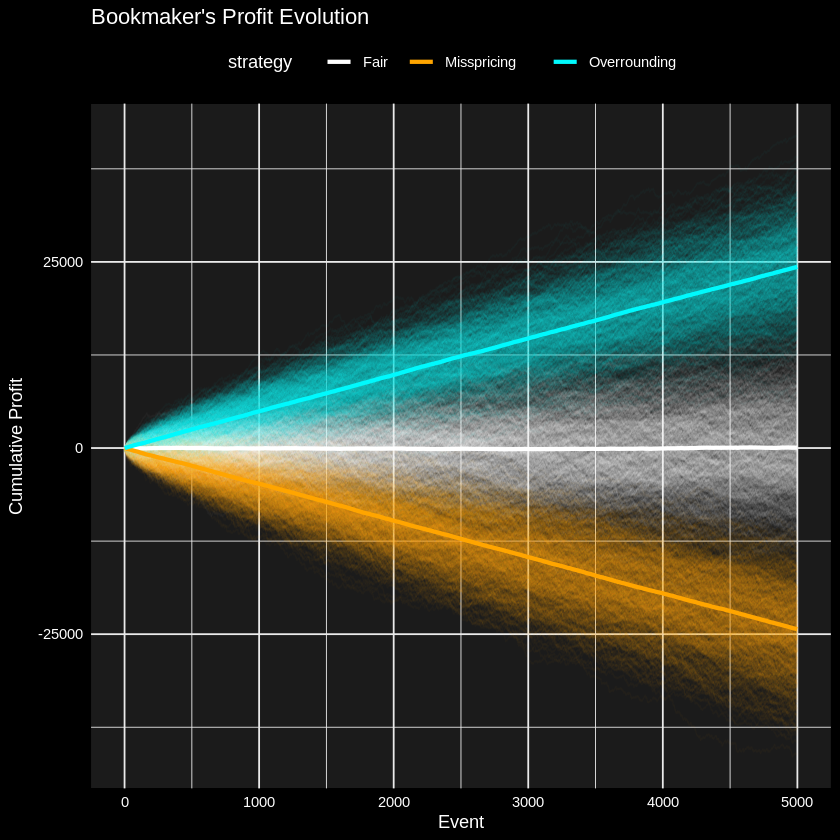

In [27]:
# Plot cumulative profit evolution (many faint sims + bold mean)
cols <- c("Fair" = "white", "Misspricing" = "orange", "Overrounding" = "#00F9FD")

ggplot() +
  geom_line(data = df_all, aes(x = event, y = cumprofit, group = interaction(strategy, sim), color = strategy),
            alpha = 0.03, size = 0.3) +
  geom_line(data = means, aes(x = event, y = mean_cum, color = strategy), size = 1.2) +
  scale_color_manual(values = cols) +
  labs(title = "Bookmaker's Profit Evolution", x = "Event", y = "Cumulative Profit") +
  theme_minimal() +
  theme(panel.background = element_rect(fill = "#1B1B1B", color = NA),
        plot.background  = element_rect(fill = "black", color = NA),
        text = element_text(color = "white"),
        axis.text = element_text(color = "white"),
        legend.position = "top")


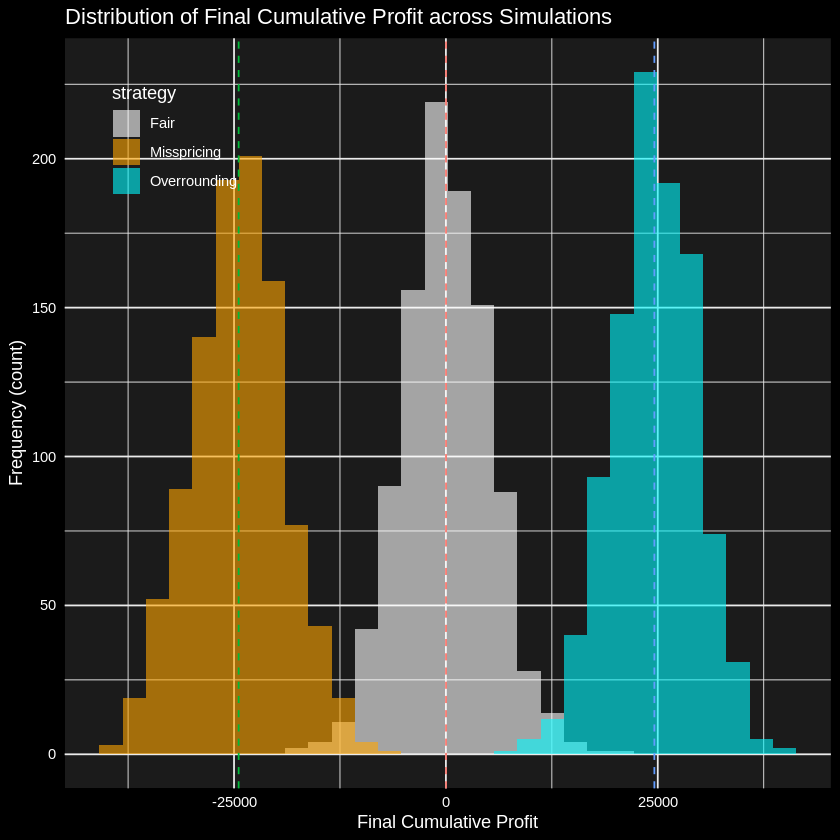

In [19]:
# Distribution of final cumulative profit (counts) — matching colors & legend top-left
final_fair <- sims_fair[nrow(sims_fair), ]
final_mis  <- sims_mis[nrow(sims_mis), ]
final_ovr  <- sims_ovr[nrow(sims_ovr), ]

df_final <- tibble(value = c(final_fair, final_mis, final_ovr),
                   strategy = rep(c("Fair","Misspricing","Overrounding"), each = length(final_fair)))

ggplot(df_final, aes(x = value, fill = strategy)) +
  geom_histogram(position = "identity", alpha = 0.6, bins = 30, color = NA) +
  scale_fill_manual(values = cols) +
  geom_vline(data = df_final %>% group_by(strategy) %>% summarize(x = mean(value)), aes(xintercept = x, color = strategy),
             linetype = "dashed", show.legend = FALSE) +
  labs(title = "Distribution of Final Cumulative Profit across Simulations", x = "Final Cumulative Profit", y = "Frequency (count)") +
  theme_minimal() +
  theme(panel.background = element_rect(fill = "#1B1B1B", color = NA),
        plot.background  = element_rect(fill = "black", color = NA),
        text = element_text(color = "white"),
        axis.text = element_text(color = "white"),
        legend.position = c(0.05, 0.95),
        legend.justification = c(0,1))

Warning message:
“The dot-dot notation (`..count..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(count)` instead.”


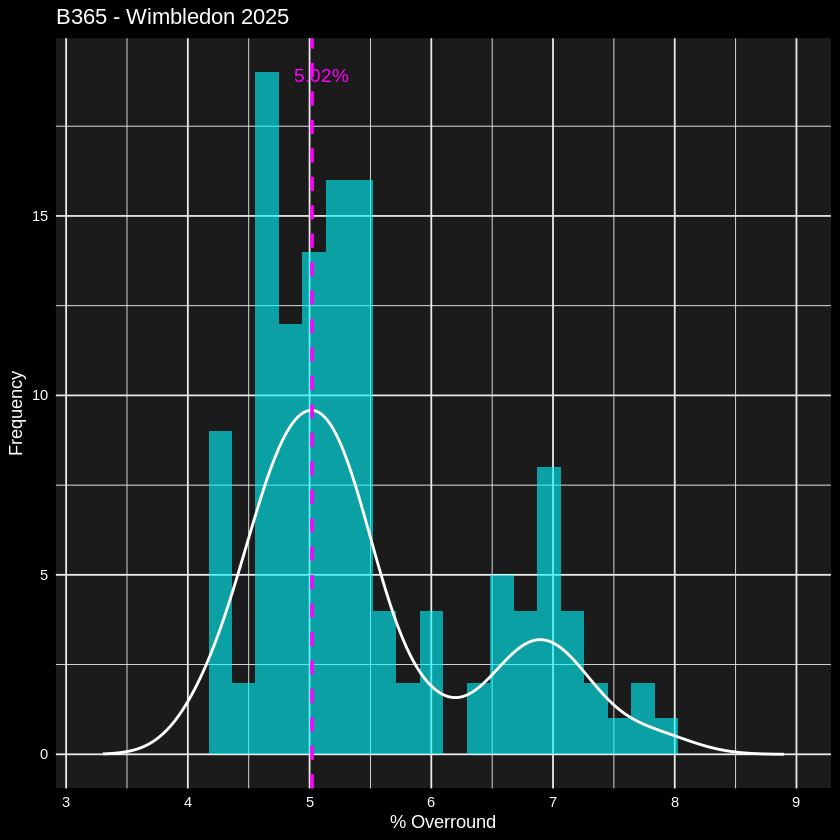

In [20]:
# Load Wimbledon odds and compute overround
url <- "https://raw.githubusercontent.com/SYGACT/spbm-p1-overrounding/refs/heads/main/wimbledon.csv"
raw_data <- read_csv(url, show_col_types = FALSE)
odds_data <- raw_data %>%
  select(Date, B365W, B365L) %>%
  drop_na() %>%
  mutate(ovr = ((1/B365W + 1/B365L) - 1) * 100)

# Estimate mode via density peak (better for continuous data)
dens <- density(odds_data$ovr)
mode_ovr <- dens$x[which.max(dens$y)]

# Histogram (counts) + scaled KDE + annotated mode (magenta)
h <- hist(odds_data$ovr, breaks = 30, plot = FALSE)
binwidth <- diff(range(odds_data$ovr)) / 30
dens_df <- tibble(x = dens$x, y = dens$y * nrow(odds_data) * binwidth)  # scale density to counts

ggplot(odds_data, aes(x = ovr)) +
  geom_histogram(aes(y = ..count..), bins = 30, fill = "#00F9FD", alpha = 0.6) +
  geom_line(data = dens_df, aes(x = x, y = y), color = "white", size = 0.8) +
  geom_vline(xintercept = mode_ovr, color = "magenta", linetype = "dashed", size = 1) +
  annotate("text", x = mode_ovr + (max(odds_data$ovr) - min(odds_data$ovr)) * 0.02,
           y = max(h$counts) * 0.9, label = sprintf("%.2f%%", mode_ovr), color = "magenta", size = 4) +
  labs(title = "B365 - Wimbledon 2025", x = "% Overround", y = "Frequency") +
  theme_minimal() +
  theme(panel.background = element_rect(fill = "#1B1B1B", color = NA),
        plot.background  = element_rect(fill = "black", color = NA),
        text = element_text(color = "white"),
        axis.text = element_text(color = "white"))

In [ ]:
summary(odds_data$ovr)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  4.186   4.762   5.159   5.465   5.919   8.012 

[1] "numeric"

In [21]:
# Parametric test: Shapiro (if feasible) + one-sample t-test vs 0
library(stats)

data <- odds_data$ovr
n <- length(data)
sample_mean <- mean(data)
sample_sd <- sd(data)

if (n <= 5000) {
  sh <- shapiro.test(data)
  cat(sprintf("Shapiro-Wilk: W=%.4f, p=%.4g\n", sh$statistic, sh$p.value))
} else {
  cat("Shapiro-Wilk: skipped (n > 5000)\n")
}

tres <- t.test(data, mu = 0)
cat(sprintf("n=%d\nmean=%.4f%% sd=%.4f%%\n", n, sample_mean, sample_sd))
cat(sprintf("One-sample t-test vs 0: t=%.4f, p=%.4g\n", tres$statistic, tres$p.value))
if (tres$p.value < 0.05) {
  cat("Result: Reject H0 at alpha=0.05 — mean differs from 0.\n")
} else {
  cat("Result: Fail to reject H0 at alpha=0.05 — no evidence mean differs from 0.\n")
}
cat("\nNote: this tests the MEAN, not the MODE. For a mode test consider a bootstrap approach.\n")

Shapiro-Wilk: W=0.8842, p=1.645e-08
n=127
mean=5.4653% sd=0.9358%
One-sample t-test vs 0: t=65.8129, p=1.944e-99
Result: Reject H0 at alpha=0.05 — mean differs from 0.

Note: this tests the MEAN, not the MODE. For a mode test consider a bootstrap approach.
